In [1]:
%load_ext nb_black
import pandas as pd
import numpy as np
from os import listdir, path

output_path = "./output"

players_df = (
    pd.concat(
        pd.read_excel(path.join(output_path, f))
        for f in listdir("./output")
        if f.startswith("season_")
    )
    .drop(columns=["Unnamed: 0"])
    .dropna()
).sort_values(["season", "rank"])
players_df

,rank,name,country,matches,mmr,season
0,1,kolemoen,DE,431,10484,M2_01 Wolf 2020
1,2,kams134,PL,923,10477,M2_01 Wolf 2020
2,3,TailBot,PL,538,10472,M2_01 Wolf 2020
3,4,Pajabol,PL,820,10471,M2_01 Wolf 2020
4,5,Adzikov,PL,1105,10442,M2_01 Wolf 2020
...,...,...,...,...,...,...
12,22460,五石散人,CN,1,96,M2_12 Wild Hunt 2020
4476,22461,Aethr3n,PL,1,96,M2_12 Wild Hunt 2020
4482,22462,Just.We,CN,1,96,M2_12 Wild Hunt 2020
4475,22463,LateNightHer0,PL,1,96,M2_12 Wild Hunt 2020


<IPython.core.display.Javascript object>

In [2]:
players_df[players_df["name"] == "sepro"]

,rank,name,country,matches,mmr,season
2084,3259,sepro,BE,142,9617,M2_05 Viper 2020
1137,1138,sepro,BE,254,9746,M2_06 Magic 2020
1166,1167,sepro,BE,260,9820,M2_07 Griffin 2020
1254,1255,sepro,BE,214,9779,M2_08 Draconid 2020
2237,12816,sepro,BE,97,3360,M2_09 Dryad 2020
1056,1057,sepro,BE,351,9846,M2_10 Cat 2020
1638,1639,sepro,BE,154,9785,M2_11 Mahakam 2020
2515,12856,sepro,BE,80,7407,M2_12 Wild Hunt 2020


<IPython.core.display.Javascript object>

In [3]:
def sdi(data) -> float:
    """
    Given a list of counts, calculate the Shannon Diversity Index

    :param data: list of integers
    :return: Shannon Diversity Index
    """

    def p(n, N):
        return n / N * np.log(n / N)

    x = np.array([d for d in data if d != 0])

    N = np.sum(x.astype("float64"))

    if N == 0:
        raise ZeroDivisionError(
            "Cannot calculate Shannon Diversity Index when the sum of all observations is zero"
        )

    return 0 - np.sum(np.array([p(n, N) for n in x]))


def dominance(data) -> float:
    N = np.sum(np.array(data).astype("float64"))

    if N > 0:
        proportions = data / N

        return np.sum(np.square(proportions))
    else:
        return np.nan


def simpson(data) -> float:
    d = dominance(data)

    if np.isnan(d):
        return np.nan
    else:
        return 1 - d

<IPython.core.display.Javascript object>

In [4]:
season_country_df = (
    players_df[players_df["rank"] <= 2000]
    .groupby(["season", "country"])
    .agg(count=pd.NamedAgg("name", "count"))
    .reset_index()
)
season_country_df

,season,country,count
0,M2_01 Wolf 2020,AE,1
1,M2_01 Wolf 2020,AM,1
2,M2_01 Wolf 2020,AR,4
3,M2_01 Wolf 2020,AT,11
4,M2_01 Wolf 2020,AU,20
...,...,...,...
947,M2_12 Wild Hunt 2020,US,121
948,M2_12 Wild Hunt 2020,UZ,2
949,M2_12 Wild Hunt 2020,VN,6
950,M2_12 Wild Hunt 2020,ZA,5


<IPython.core.display.Javascript object>

In [5]:
season_diversity_df = (
    season_country_df.groupby(["season"])
    .agg(
        richness=pd.NamedAgg("count", "count"),
        shannon_diversity=pd.NamedAgg("count", sdi),
        dominance=pd.NamedAgg("count", dominance),
        simpson=pd.NamedAgg("count", simpson),
    )
    .reset_index()
)
season_diversity_df

,season,richness,shannon_diversity,dominance,simpson
0,M2_01 Wolf 2020,79,2.911451,0.109716,0.890284
1,M2_02 Love 2020,73,2.784907,0.124585,0.875415
2,M2_03 Bear 2020,74,2.770397,0.123829,0.876171
3,M2_04 Elf 2020,78,2.921609,0.105208,0.894792
4,M2_05 Viper 2020,82,2.975021,0.106955,0.893045
5,M2_06 Magic 2020,79,3.028216,0.100404,0.899596
6,M2_07 Griffin 2020,80,3.085621,0.092351,0.907649
7,M2_08 Draconid 2020,83,3.043551,0.097257,0.902743
8,M2_09 Dryad 2020,83,3.071002,0.093658,0.906342
9,M2_10 Cat 2020,82,3.028427,0.101374,0.898626


<IPython.core.display.Javascript object>

In [6]:
summary_df = (
    players_df.groupby(["season"])
    .agg(
        players_found=pd.NamedAgg("name", "count"),
        players_total=pd.NamedAgg("rank", "max"),
    )
    .reset_index()
)

summary_df["players_captured"] = (
    summary_df["players_found"] * 100 / summary_df["players_total"]
)
summary_df["extra_players_captured"] = (
    (summary_df["players_found"] - 2860) * 100 / (summary_df["players_total"] - 2860)
)
summary_df

,season,players_found,players_total,players_captured,extra_players_captured
0,M2_01 Wolf 2020,2905,2997,96.930264,32.846715
1,M2_02 Love 2020,3984,4883,81.589187,55.561048
2,M2_03 Bear 2020,4772,6632,71.954162,50.689290
3,M2_04 Elf 2020,6070,10209,59.457342,43.679412
4,M2_05 Viper 2020,5977,10079,59.301518,43.177725
5,M2_06 Magic 2020,6104,9919,61.538462,45.955518
6,M2_07 Griffin 2020,7372,14791,49.841120,37.817450
7,M2_08 Draconid 2020,7037,13800,50.992754,38.180987
8,M2_09 Dryad 2020,7056,14554,48.481517,35.881649
9,M2_10 Cat 2020,6987,16011,43.638748,31.381644


<IPython.core.display.Javascript object>

In [7]:
season_df = pd.read_excel("./output/seasonal_stats.xlsx").drop(
    columns=["Unnamed: 0", "min_mmr", "max_mmr", "num_matches"]
)
estimates_df = pd.read_excel("./output/player_estimates.xlsx").drop(
    columns=["Unnamed: 0"]
)
merged_df = pd.merge(summary_df, season_diversity_df, how="left", on="season")
merged_df = pd.merge(merged_df, season_df, how="left", on="season")
merged_df = pd.merge(merged_df, estimates_df, how="left", on="season")
merged_df

,season,players_found,players_total,players_captured,extra_players_captured,richness,shannon_diversity,dominance,simpson,top500_cutoff,top200_cutoff,top64_cutoff,low_estimate,high_estimate,mean_estimate,std_err
0,M2_01 Wolf 2020,2905,2997,96.930264,32.846715,79,2.911451,0.109716,0.890284,9749,9872,10061,2900.000000,3600,3117.636364,124.944153
1,M2_02 Love 2020,3984,4883,81.589187,55.561048,73,2.784907,0.124585,0.875415,9832,9952,10117,4566.666667,7100,5620.242424,441.315936
2,M2_03 Bear 2020,4772,6632,71.954162,50.689290,74,2.770397,0.123829,0.876171,9867,9995,10204,6036.363636,10300,7329.272727,760.229978
3,M2_04 Elf 2020,6070,10209,59.457342,43.679412,78,2.921609,0.105208,0.894792,9952,10087,10293,9927.272727,18000,12319.454545,1494.370140
4,M2_05 Viper 2020,5977,10079,59.301518,43.177725,82,2.975021,0.106955,0.893045,9910,10028,10255,7766.666667,11400,9372.060606,727.332197
5,M2_06 Magic 2020,6104,9919,61.538462,45.955518,79,3.028216,0.100404,0.899596,9896,10002,10191,6800.000000,9800,8320.181818,618.201230
6,M2_07 Griffin 2020,7372,14791,49.841120,37.817450,80,3.085621,0.092351,0.907649,9978,10100,10289,12836.363636,19900,14683.272727,1331.618216
7,M2_08 Draconid 2020,7037,13800,50.992754,38.180987,83,3.043551,0.097257,0.902743,9946,10061,10246,9566.666667,13300,11186.242424,696.853229
8,M2_09 Dryad 2020,7056,14554,48.481517,35.881649,83,3.071002,0.093658,0.906342,9946,10046,10183,9733.333333,12580,11218.666667,458.757501
9,M2_10 Cat 2020,6987,16011,43.638748,31.381644,82,3.028427,0.101374,0.898626,9977,10067,10176,12800.000000,14620,13774.181818,369.275995


<IPython.core.display.Javascript object>

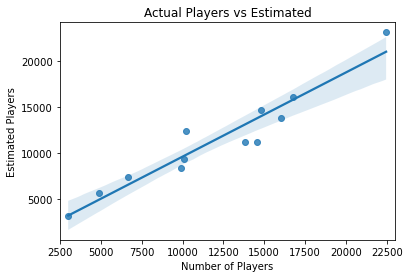

<IPython.core.display.Javascript object>

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(data=merged_df, x="players_total", y="mean_estimate")
plt.title("Actual Players vs Estimated")
plt.xlabel("Number of Players")
plt.ylabel("Estimated Players")
plt.xlim(2500, 23000)
plt.show()